In [1]:
import numpy as np
import pandas as pd
import math
import datetime
import sys
import os

from prophet import Prophet

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt

Importing plotly failed. Interactive plots will not work.


In [2]:
def smape(actual, predicted) -> float:  
    temporary_smape_nominator = np.abs(np.array(actual) - np.array(predicted))
    temporary_smape_denominator = [np.max(elem) for elem in list(zip(predicted, actual))]

    return float(np.sum(temporary_smape_nominator) / np.sum(temporary_smape_denominator))

def regression_insights(actual, predicted) -> tuple: 
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    return mse, rmse, mae, r2

def bias(actual, predicted) -> float:
    return float(np.sum(np.abs(1 - np.array(predicted) / np.array(actual + 0.00000001))))

In [3]:
daily_data = pd.read_csv("../podaci/vremenske-serije/date_day_norm.csv")
daily_data = daily_data.astype({'date': 'datetime64[ns]'})

# 1. koji range imamo:
min_date = daily_data['date'].min()
max_date = daily_data['date'].max()
daily_data.set_index('date', inplace=True)

date_range = pd.date_range(min_date, max_date, freq='D')

# 2. left-join na date_range sa našim datumima
date_range_series = pd.Series(index=date_range, dtype='int64')
daily_data_filled = pd.concat([daily_data,
                               date_range_series[~date_range_series.index.isin(daily_data.index)]]).sort_index()

daily_data_filled = daily_data_filled.drop([0], axis=1).fillna(0).astype({'demand_value': 'float32'})
daily_data_filled['date'] = daily_data_filled.index
daily_data_filled.reset_index(drop=True, inplace=True)

# izbaci nedelje iz podataka i vidi kako izgledaju stvari bez njih -> -> ->
no_sundays_data = daily_data_filled[daily_data_filled['date'].apply(lambda x: pd.to_datetime(x).day_name()) != 'Sunday'].reset_index(drop=True)

In [4]:
prophet_data =  no_sundays_data.copy()
prophet_data = prophet_data.rename(columns={"demand_value": "y", "date": "ds"})
prophet_data.head(10)

,y,ds
0,0.098039,2019-12-18
1,0.245098,2019-12-19
2,0.401961,2019-12-20
3,0.000000,2019-12-21
4,0.490196,2019-12-23
5,0.000000,2019-12-24
6,0.000000,2019-12-25
7,0.000000,2019-12-26
8,0.519608,2019-12-27
9,0.019608,2019-12-28


In [5]:
def run_prophet(prophet_train_pd, prophet_test_pd, model_info, look_ahead=28):
    history = prophet_train_pd.copy()

    predictions = []
    
    # if needed at some point to see coeffs
    forecasts_df = []
  
    for instance in range(len(prophet_test_pd)):
        future_to_predict_dates = []        
        start_date = prophet_test_pd.iloc[instance]['ds']
        current_date = start_date
        num_of_days = 0
        
        while num_of_days < look_ahead:
            if current_date.day_name() != 'Sunday':
                num_of_days += 1
                future_to_predict_dates.append(current_date)
            current_date += pd.Timedelta(days=1)
        
        future_to_predict = pd.DataFrame(future_to_predict_dates, 
                                         columns=["ds"])

        model = eval(model_info)
        
        orig_out = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        model.fit(history)
        sys.stdout = orig_out

        # freq="W-MON" is to put Monday as an ancor, instead of Sunday
        # alternative: `+= np.timedelta64(1, 'D')`
#         future_to_predict = model.make_future_dataframe(periods=look_ahead, 
#                                                         freq="W-MON", 
#                                                         include_history=False)

        forecast = model.predict(future_to_predict)
        forecasts_df.append(forecast)

        ys_predicted = forecast['yhat'].values

        dates = [pd.to_datetime(x).date() for x in future_to_predict['ds'].values]
        date_prediction = list(zip(dates, ys_predicted))
        predictions.append(date_prediction)

        test_instance = prophet_test_pd.iloc[instance]
        history = history.append(test_instance)

    return predictions, forecasts_df, prophet_train_pd, prophet_test_pd, model

def run_model(model_info, 
              data_sorted_by_date, 
              date_col="ds", 
              date_to_start="2021-03-01", 
              look_ahead=28):
    
    train_pd = data_sorted_by_date[data_sorted_by_date[date_col] < date_to_start]
    test_pd =  data_sorted_by_date[data_sorted_by_date[date_col] >= date_to_start]

    prophet_predictions, prophet_forecasts_df, prophet_train_pd, prophet_test_pd, prophet_model = \
        run_prophet(train_pd, test_pd, model_info, look_ahead)
    
    return prophet_predictions, prophet_model


In [6]:
models = {
  "prophet_weekly_and_monthly_and_holidays": 
    "Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False).add_seasonality(name='monthly', period=30.5, fourier_order=5).add_country_holidays(country_name='SWE')",
  "prophet_weekly_and_monthly_and_holidays_more_flexible_trend": 
    "Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False, changepoint_prior_scale=0.09).add_seasonality(name='monthly', period=30.5, fourier_order=5).add_country_holidays(country_name='SWE')",
  "prophet_daily_weekly_monthly_and_holidays": 
    "Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False).add_seasonality(name='monthly', period=30.5, fourier_order=5).add_country_holidays(country_name='SWE')",
  "prophet_daily_weekly_monthly_and_holidays_more_flexible_trend": 
    "Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False, changepoint_prior_scale=0.09).add_seasonality(name='monthly', period=30.5, fourier_order=5).add_country_holidays(country_name='SWE')"
}    

results = {}

date_to_start = "2021-03-01"
look_ahead = 28 #dana
date_col = "ds"

train_pd = prophet_data[prophet_data[date_col] < date_to_start]
test_pd =  prophet_data[prophet_data[date_col] >= date_to_start]

for model_name, model_info in models.items():
    print(model_info)  
    run_returned = run_model(model_info=model_info, 
                             data_sorted_by_date=prophet_data, 
                             date_col="ds", 
                             date_to_start=date_to_start, 
                             look_ahead=look_ahead)
    
    results[model_name] = run_returned
    print()

Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False).add_seasonality(name='monthly', period=30.5, fourier_order=5).add_country_holidays(country_name='SWE')
Initial log joint probability = -45.3542
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       656.439     0.0083465       65.2181           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       657.481    0.00244434       76.4075   2.938e-05       0.001      295  LS failed, Hessian reset 
     199       657.607   0.000279851       71.7907           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254        657.65   1.32088e-05       69.5789   1.496e-07       0.001      411  LS failed, Hessian reset 
     275        657.65   7.11357e-09       74.5367    0.004141       0.493      442   
Optimization 

Initial log joint probability = -19.6367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       679.714    0.00116197       66.4022      0.5713      0.5713      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       679.911   1.11838e-06       81.5082      0.1954      0.1954      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       680.149    0.00128848       97.9504           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335         680.4   0.000461595       64.2058   7.839e-06       0.001      455  LS failed, Hessian reset 
     399       680.763   0.000248058       58.8493      0.1677           1      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     466       680.774   9.36915e-09    

Initial log joint probability = -20.0685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.786   0.000449288       81.8444           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       700.909   0.000402029       85.7802   4.894e-06       0.001      279  LS failed, Hessian reset 
     199       700.928   2.33036e-05       69.8428      0.5627      0.5627      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       700.954   4.31512e-07       77.1236           1           1      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       700.954   1.04297e-07       70.7069      0.3286      0.9543      415   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

Initial log joint probability = -49.692
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.047   0.000421917        76.112      0.2043      0.2043      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       718.409   0.000693303       80.2781   9.995e-06       0.001      236  LS failed, Hessian reset 
     199       718.647   3.97326e-05        79.467           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232        718.65   6.89493e-08       63.7881           1           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -50.148
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.956   0.000633459       68.6362      0.8452      0.8452

Initial log joint probability = -20.7648
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       734.374    0.00828963         72.28       0.385           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       734.836   0.000182832       69.3717   2.373e-06       0.001      226  LS failed, Hessian reset 
     199       735.222   1.18915e-06       75.5818           1           1      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       735.224   3.61239e-06       71.6978   4.687e-08       0.001      371  LS failed, Hessian reset 
     239       735.224   4.32401e-08       66.8629      0.5842      0.5842      401   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.2552
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -51.5581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       752.216    0.00106264        75.971      0.7073      0.7073      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       752.783    0.00138627       65.6305   1.805e-05       0.001      254  LS failed, Hessian reset 
     199       752.852   0.000119172       70.0742           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       753.245   2.32676e-06       68.6263     0.05448      0.5066      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     317       753.245   5.64615e-08       64.9298     0.07229           1      423   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

Initial log joint probability = -22.1606
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       764.301    0.00648737        64.903           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       765.314   0.000449952       95.2553   5.959e-06       0.001      279  LS failed, Hessian reset 
     199        765.36   8.44911e-06       53.9587      0.2742      0.2742      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       765.712   6.99221e-06       75.0026       1.139      0.3471      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       765.718   5.88362e-05       80.5283   8.048e-07       0.001      497  LS failed, Hessian reset 
     339       765.721   4.82006e-09       68.4362     0.02889           1      539   
Optimization terminat

Initial log joint probability = -52.1006
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       782.981    0.00469517       75.0315           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       784.203   0.000619489       64.5955   1.004e-05       0.001      198  LS failed, Hessian reset 
     184       784.475   9.40275e-06       68.0283   1.121e-07       0.001      326  LS failed, Hessian reset 
     199       784.475   1.03653e-07       59.9619      0.5302      0.5302      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       784.475   7.46411e-09       69.9304      0.2036      0.2036      370   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -26.0626
    Iter      log prob        ||dx||      ||grad||    

Initial log joint probability = -22.0358
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        805.12   9.72017e-05        75.527      0.4921      0.4921      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       805.364   0.000538172         72.63   7.051e-06       0.001      212  LS failed, Hessian reset 
     174        805.39   3.25205e-05       82.5208   4.888e-07       0.001      303  LS failed, Hessian reset 
     199       805.394   1.73095e-07       66.7637           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       805.455   3.98653e-07       67.3347           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       805.457   4.14437e-08       70.1349      0.4721      0.4721      526   
Optimization terminat

Initial log joint probability = -18.4279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       675.436   0.000505344       36.8834           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       675.557    0.00169356        57.944   4.067e-05       0.001      177  LS failed, Hessian reset 
     199       676.091    0.00018615       41.8502      0.5732      0.5732      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       676.139   0.000300732       47.0927   5.758e-06       0.001      351  LS failed, Hessian reset 
     299       676.152   3.08104e-05       35.2778      0.8057      0.8057      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       676.152   8.49732e-08       43.1275      0.5928      0.5928      489   
Optimization terminat

Initial log joint probability = -20.6454
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       692.244     0.0011513       42.3209           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       692.763    0.00113478        76.713   1.513e-05       0.001      197  LS failed, Hessian reset 
     164       693.018   0.000225801       35.8131   4.605e-06       0.001      270  LS failed, Hessian reset 
     199       693.031   1.61689e-05       42.0431           1           1      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       693.032   1.62918e-05       37.6631   3.748e-07       0.001      352  LS failed, Hessian reset 
     235       693.032   2.07607e-06       47.0561   5.984e-08       0.001      437  LS failed, Hessian reset 
     248       693.032   1.10992e-07       36.2904      0.6256   

Initial log joint probability = -19.5285
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       711.579   0.000678935       44.3813    1.36e-05       0.001      147  LS failed, Hessian reset 
      99       711.641   0.000512917       36.0001      0.9584      0.9584      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       712.222   0.000248481       43.2262           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       712.287   0.000509044       33.1157           1           1      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       712.466    0.00123499       42.9192   2.859e-05       0.001      523  LS failed, Hessian reset 
     399       712.582   0.000793405       40.4739           1           1      573   
    Iter      log pro

Initial log joint probability = -20.4559
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       723.036    0.00145361       46.0081       2.361      0.2361      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       723.921   7.96477e-05       33.8667   2.079e-06       0.001      270  LS failed, Hessian reset 
     199       723.924   1.83219e-05        41.336       0.704       0.704      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       723.925   7.56902e-08       37.9882      0.2593           1      367   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -50.1783
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       725.734    0.00267774        37.575           1          

Initial log joint probability = -50.4297
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       737.979    0.00477842       35.4577           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       738.845    0.00261728       79.1976   7.116e-05       0.001      161  LS failed, Hessian reset 
     194       739.663   2.62402e-05       46.9384   6.347e-07       0.001      301  LS failed, Hessian reset 
     199       739.664   4.29808e-06       37.9386      0.5619      0.5619      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       739.664   1.13846e-07       41.7145           1           1      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.62
    Iter      log prob        ||dx||      ||grad||     

Initial log joint probability = -22.1594
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       752.984    0.00119929       55.1627   3.029e-05       0.001      151  LS failed, Hessian reset 
      99       753.072   0.000414698       34.1207           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       753.099   0.000207122       42.0559   5.586e-06       0.001      219  LS failed, Hessian reset 
     149       753.108   2.51814e-05       43.6897   7.023e-07       0.001      303  LS failed, Hessian reset 
     195       753.279    0.00375788       60.4237   6.822e-05       0.001      394  LS failed, Hessian reset 
     199        753.32   0.000644807        33.427      0.6279      0.6279      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       753.737    0.00205074       43.5754           1   

Initial log joint probability = -20.8361
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       768.629     0.0266974       51.2457      0.2272           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       769.303   0.000996736       47.2028   2.642e-05       0.001      207  LS failed, Hessian reset 
     179       769.633   4.24702e-05       41.5738   1.013e-06       0.001      299  LS failed, Hessian reset 
     199       769.634   5.90644e-07       35.0617           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       769.634   2.72727e-08       31.4479      0.2682      0.7291      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.8644
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -22.6034
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       778.691   0.000227446        43.471       0.239       0.239      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       779.779    0.00054444       39.7415       0.922       0.922      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       779.803   0.000148936       36.9253   3.318e-06       0.001      288  LS failed, Hessian reset 
     249       779.811   9.59853e-05       36.5847    1.97e-06       0.001      385  LS failed, Hessian reset 
     299       779.817    0.00035185       44.7411           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       779.831   2.92528e-05       33.5201   6.742e-07       0.001      577  LS failed, Hessian rese

Initial log joint probability = -54.5485
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       791.107    0.00186012       114.807   3.213e-05       0.001      146  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       792.362    0.00165258       34.7804       2.297      0.2297      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       792.445   0.000948564       47.8149   2.367e-05       0.001      356  LS failed, Hessian reset 
     299       792.703   0.000343957       51.8339      0.5373      0.5373      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       792.847   0.000253957         34.08    6.94e-06       0.001      528  LS failed, Hessian reset 
     370       792.881   2.92689e-05       36.3376   7.118e-07       0.001      621 

Initial log joint probability = -54.2177
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       808.049      0.028941       182.741      0.6662           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       809.118    0.00099148       50.1337   2.742e-05       0.001      217  LS failed, Hessian reset 
     199       809.159   0.000142441       31.2547           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       809.437     0.0014912       43.8935   3.514e-05       0.001      405  LS failed, Hessian reset 
     287       809.487   2.19865e-05        36.614   5.147e-07       0.001      499  LS failed, Hessian reset 
     299       809.487   4.13112e-07       36.6876      0.4769      0.4769      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -19.7416
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        659.26   0.000611934       74.1277      0.6211      0.6211      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       659.406   0.000535909       97.6575   5.454e-06       0.001      219  LS failed, Hessian reset 
     199       659.451   3.21234e-07       69.1764      0.3977      0.3977      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       659.747   0.000752931       79.4393      0.6683      0.6683      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     366       659.997   0.000812688       86.1099   1.444e-05       0.001      520  LS failed, Hessian reset 
     399       660.076   9.90537e-05       89.9048           1           1      562   
    Iter      log pro

Initial log joint probability = -47.6829
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       681.247     0.0141341       99.0278           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       682.079   0.000429377       75.4412   4.191e-06       0.001      287  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       682.403   2.24345e-06       76.9677      0.2729      0.2729      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       682.587    6.7458e-06       78.9479      0.7685      0.7685      523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     420       682.587    7.7029e-09       74.4124      0.2396           1      552   
Optimization terminated normally: 
  Con

Initial log joint probability = -20.0685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       700.199   0.000801451       105.244   8.024e-06       0.001      163  LS failed, Hessian reset 
      99       700.219   0.000568281       94.2909           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193        701.25    0.00156166       88.2906   1.943e-05       0.001      313  LS failed, Hessian reset 
     199       701.328   0.000278813       68.7714       1.254      0.1254      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       701.358   4.36859e-08        64.613      0.2769           1      444   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -19.5285
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -50.148
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.344     0.0132812       84.5008      0.3412           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       721.532     0.0012711       88.2737       0.603       0.603      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       721.722   6.85418e-05       65.8884   9.477e-07       0.001      353  LS failed, Hessian reset 
     299       721.815    0.00108731        107.39     0.05519      0.6752      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       721.822   0.000784105       109.972   7.301e-06       0.001      484  LS failed, Hessian reset 
     362       721.861   2.80775e-05       75.8138   3.194e-07       0.001      614  LS failed, Hessian reset

Initial log joint probability = -20.7648
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       734.401   0.000291348       69.3011      0.6685      0.6685      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       734.924   0.000771724        81.127   9.815e-06       0.001      225  LS failed, Hessian reset 
     199       734.991   2.10886e-05       62.9571      0.3665      0.3665      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       734.992    1.4069e-05       83.3853   2.137e-07       0.001      338  LS failed, Hessian reset 
     228       734.994   4.38181e-08       75.2503      0.3044      0.3044      371   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.2552
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -20.8361
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       756.982    0.00683785       95.0444       0.897       0.897      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179        757.42   1.54017e-06       76.4631   1.812e-08       0.001      259  LS failed, Hessian reset 
     192        757.42   2.90559e-08       71.0254      0.2081           1      277   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.8644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       759.119    0.00215552       79.1863           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       759.309   3.10764e-09       79.1175     0.05811     0.058

Initial log joint probability = -52.1354
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       767.007   0.000655826       100.029    5.89e-06       0.001      128  LS failed, Hessian reset 
      99       769.387    0.00468856       106.635      0.7661      0.7661      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       771.152   0.000287705       71.3628           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292        771.33   0.000419952       58.0241   4.527e-06       0.001      440  LS failed, Hessian reset 
     299       771.382   0.000223676       67.6387      0.9612      0.9612      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       771.738     0.0021243       65.5939           1           1      575   
    Iter      log pro

Initial log joint probability = -22.9306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96        787.23   0.000456824       72.7148   5.807e-06       0.001      175  LS failed, Hessian reset 
      99       787.264   0.000415722       66.1397           1           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       787.682   0.000607341         75.97    8.14e-06       0.001      272  LS failed, Hessian reset 
     199        788.12   0.000102496       80.8745           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     286       788.198    7.2888e-05       67.2555   1.094e-06       0.001      523  LS failed, Hessian reset 
     299       788.202   1.78642e-05       65.9451      0.6114      0.6114      538   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -22.0358
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        804.75   0.000532263       56.8377           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       805.147   0.000217624       75.5981    2.89e-06       0.001      257  LS failed, Hessian reset 
     199       805.175   3.39492e-05       62.3311      0.7572      0.7572      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       805.182   3.90846e-05       73.3669   4.996e-07       0.001      368  LS failed, Hessian reset 
     299       805.202   0.000272403       77.3469           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       805.995   6.47218e-06       66.4859      0.3031      0.3031      586   
    Iter      log pro

Initial log joint probability = -46.9561
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       676.955    0.00164599       52.6673       0.929       0.929      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       678.338   0.000156674       38.0402   3.322e-06       0.001      266  LS failed, Hessian reset 
     199       678.345   1.07428e-05       45.3472      0.4284           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       678.463   2.97797e-05       39.9668      0.7616      0.7616      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       678.465   6.07194e-05       38.7382   1.137e-06       0.001      444  LS failed, Hessian reset 
     398        678.48   0.000221359       40.4785   4.502e-06       0.001      610  LS failed, Hessian rese

Initial log joint probability = -22.312
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        693.93   0.000576138       35.4102      0.5011      0.5011      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       694.953   0.000934649       39.5765           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       695.033   0.000416173       68.2635   8.619e-06       0.001      321  LS failed, Hessian reset 
     295       695.241   1.12352e-05        29.661   2.718e-07       0.001      481  LS failed, Hessian reset 
     299       695.241   7.25801e-06       42.0554           1           1      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       695.242   1.14183e-06       49.8686   2.678e-08       0.001      563  LS failed, Hessian reset

Initial log joint probability = -20.0685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       708.958    0.00360943       65.5758           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       709.672    0.00231486       51.4005   5.441e-05       0.001      200  LS failed, Hessian reset 
     199       710.049   0.000589925        39.117      0.6343           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       710.052   0.000212135       43.2748   5.423e-06       0.001      346  LS failed, Hessian reset 
     238       710.057   6.46439e-07       35.4004   1.828e-08       0.001      433  LS failed, Hessian reset 
     246       710.057   2.24821e-08       31.4332      0.3038           1      446   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

Initial log joint probability = -50.1783
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       724.379    0.00622158        59.404           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       726.008   0.000819245       60.2148   1.771e-05       0.001      251  LS failed, Hessian reset 
     199       726.147   0.000108587       47.5095      0.9148      0.9148      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270        726.22   8.15332e-05       45.4837   1.817e-06       0.001      445  LS failed, Hessian reset 
     299       726.222   3.96952e-07        43.492      0.4798           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     380       726.225   1.71272e-07       39.1777      0.3323           1      589   
Optimization terminat

Initial log joint probability = -20.2477
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       742.278   0.000873471       33.7627           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       743.003   0.000389103       55.1965   7.556e-06       0.001      197  LS failed, Hessian reset 
     199       743.493   2.16379e-06       33.6099      0.4572      0.4572      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       743.493   1.48436e-06       36.0126   3.958e-08       0.001      357  LS failed, Hessian reset 
     236       743.493    5.8712e-08       36.7484           1           1      371   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.7648
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -20.9652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       756.693    0.00881065       92.3738           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       758.104   0.000532849       74.8393   9.457e-06       0.001      251  LS failed, Hessian reset 
     199       758.312   0.000853139       46.9814           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       758.437    0.00185704       118.782   5.192e-05       0.001      326  LS failed, Hessian reset 
     261       758.603    0.00012719        38.108    2.52e-06       0.001      434  LS failed, Hessian reset 
     299       758.606   9.28856e-07       37.5124           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -21.7063
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       772.529    0.00179177       40.8779           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       772.867   0.000262425       45.2341   6.487e-06       0.001      209  LS failed, Hessian reset 
     199       773.363     0.0197986       46.7958       2.673           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       773.395   0.000245919       38.6368    5.26e-06       0.001      343  LS failed, Hessian reset 
     290       773.752   0.000947395       30.9696   2.331e-05       0.001      496  LS failed, Hessian reset 
     299       773.765   8.53012e-05         31.76      0.8549      0.8549      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -52.1354
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       780.369    0.00425385       118.626           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       783.286   0.000292109       46.8411      0.2809           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       783.624   7.25636e-06       35.8301      0.6351      0.6351      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     321       783.629   5.34613e-05       36.5073   1.141e-06       0.001      431  LS failed, Hessian reset 
     356        783.63   5.63221e-08       34.1985      0.4404      0.4404      484   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

Initial log joint probability = -26.0626
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       796.178     0.0236025       59.8601          10           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       797.947    0.00175362       137.588    3.23e-05       0.001      262  LS failed, Hessian reset 
     199       798.064   0.000238983       42.5786      0.6336      0.6336      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       798.265   4.88172e-07       35.7702           1           1      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       798.265    8.5226e-08       32.8909           1           1      427   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

Initial log joint probability = -22.6073
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       811.831    0.00354845       44.4333           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        813.01   3.24261e-05       45.1072           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265        813.44   0.000393616       43.0836     1.2e-05       0.001      360  LS failed, Hessian reset 
     299       813.648    4.2615e-05       38.1402      0.4883      0.4883      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       813.652   2.09885e-05       29.3618   5.605e-07       0.001      506  LS failed, Hessian reset 
     385       813.655   1.57182e-05       42.2769   3.944e-07       0.001      607  LS failed, Hessian rese

In [7]:
T_data = {}

for model_name in results.keys():
    for i in range(look_ahead):
        T_data[f'model__{model_name}__T{i+1}'] = [x[i] for x in results[model_name][0]]
    
final_df = no_sundays_data.copy()

for model_name in T_data.keys():
    example_df = pd.DataFrame()
    example_df['date'] = [x[0] for x in T_data[model_name]]
    example_df = example_df.astype({'date': 'datetime64[ns]'})
    example_df[model_name] = [x[1] for x in T_data[model_name]]
  
    final_df = final_df.merge(example_df, on='date', how='left')

In [8]:
# 2021-04-01
final_df_2021_04_01 = final_df.dropna(axis=0, how='any')
actual = final_df_2021_04_01[['date', 'demand_value']]

In [9]:
columns = final_df.columns
metrics = []

for column in columns:
    if column.startswith("model"):
        df = final_df_2021_04_01[['date', column]]
        
        dict_metrics = {}
        dict_metrics['model'] = column
        
        if (actual['date'] == df['date']).all():
            mse, rmse, mae, r2 = regression_insights(actual['demand_value'], df[column])
            dict_metrics['mse'] = mse
            dict_metrics['rmse'] = rmse
            dict_metrics['mae'] = mae
            dict_metrics['r2'] = r2
            
            smape_value = smape(actual['demand_value'], df[column])
            dict_metrics['smape'] = smape_value
            
            bias_value = bias(actual['demand_value'], df[column])
            dict_metrics['bias'] = bias_value
            metrics.append(dict_metrics.copy())

metrics_df = pd.DataFrame.from_dict(metrics)

In [10]:
list(metrics_df[metrics_df['model'].apply(lambda x: x[-2:]) == "T1"]['model'])

['model__prophet_weekly_and_monthly_and_holidays__T1',
 'model__prophet_weekly_and_monthly_and_holidays_more_flexible_trend__T1',
 'model__prophet_daily_weekly_monthly_and_holidays__T1',
 'model__prophet_daily_weekly_monthly_and_holidays_more_flexible_trend__T1']

In [11]:
metrics_df[metrics_df['model'].apply(lambda x: x[-2:]) == "T1"]

,model,mse,rmse,mae,r2,smape,bias
0,model__prophet_weekly_and_monthly_and_holidays...,0.038284,0.195662,0.120943,0.822962,0.141016,1.147073e+08
28,model__prophet_weekly_and_monthly_and_holidays...,0.032307,0.179741,0.113431,0.850600,0.129801,1.042483e+08
56,model__prophet_daily_weekly_monthly_and_holida...,0.035445,0.188267,0.119556,0.836090,0.139296,1.055394e+08
84,model__prophet_daily_weekly_monthly_and_holida...,0.032443,0.180120,0.113918,0.849969,0.130383,1.054744e+08


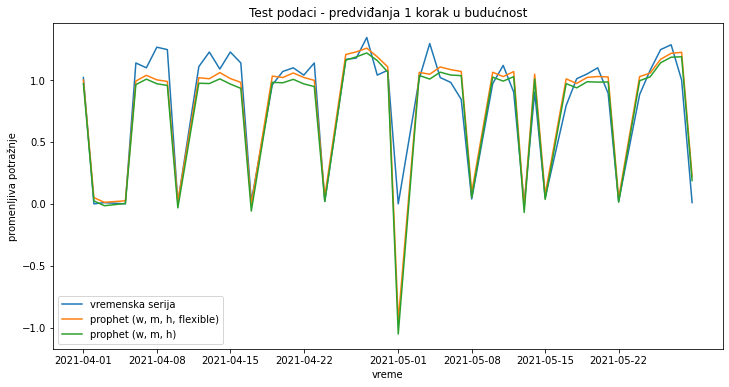

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(final_df_2021_04_01['date'],
         actual['demand_value'], label='vremenska serija')
plt.plot(final_df_2021_04_01['date'],
         final_df_2021_04_01['model__prophet_weekly_and_monthly_and_holidays_more_flexible_trend__T1'], label='prophet (w, m, h, flexible)')
plt.plot(final_df_2021_04_01['date'],
         final_df_2021_04_01['model__prophet_weekly_and_monthly_and_holidays__T1'], label='prophet (w, m, h)')

plt.title("Test podaci - predviđanja 1 korak u budućnost")
plt.xlabel("vreme")
plt.ylabel("promenljiva potražnje")
plt.legend()
plt.savefig("../../grafici/test_dnevni_prophet.eps", dpi=300)
plt.show()

In [13]:
if 'day_name' not in daily_data_filled.columns:
    daily_data_filled.insert(0, "day_name", daily_data_filled['date'].apply(lambda x: pd.to_datetime(x).day_name()))
    daily_data_filled

In [14]:
daily_data_filled

,day_name,demand_value,date
0,Wednesday,0.098039,2019-12-18
1,Thursday,0.245098,2019-12-19
2,Friday,0.401961,2019-12-20
3,Saturday,0.000000,2019-12-21
4,Sunday,0.000000,2019-12-22
...,...,...,...
524,Tuesday,1.078431,2021-05-25
525,Wednesday,1.245098,2021-05-26
526,Thursday,1.284314,2021-05-27
527,Friday,1.000000,2021-05-28


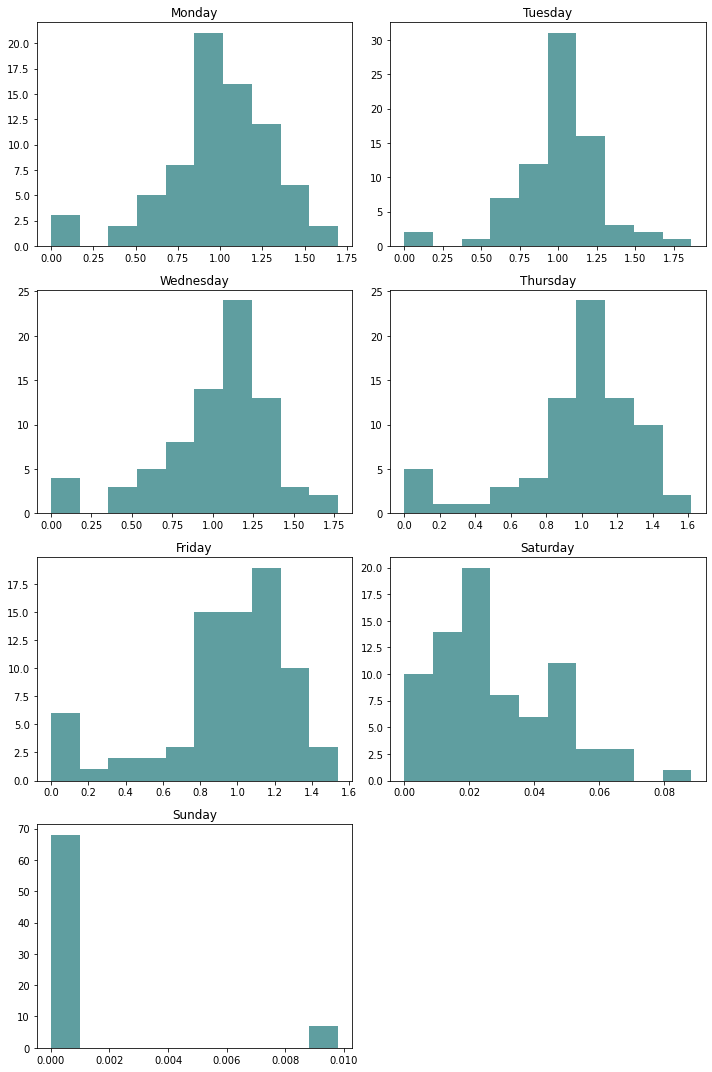

In [15]:
# daily_data_filled.groupby(by="day_name")['number_of_bookings'].describe()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_range = {}

for day in days:
    day_range[day] = list(daily_data_filled[daily_data_filled['day_name'] == day]['demand_value'])   
    
fig, ax = plt.subplots(4, 2, figsize=(10,15))
ax = ax.flatten()

for i, day in enumerate(days):
    ax[i].hist(day_range[day], color='cadetblue')
        
    ax[i].set_title(day)

ax[7].remove()

plt.tight_layout()
plt.show()